# Visual Inspection of Motorcycle Connecting Rods
## Task 2

The system must be robust to the following changes in the working images:
1.  The inspection area may be dirty due to the presence of scattered iron powder
2.  Images may contain other objects (i.e. screws and washers) that need not to be analysed by the 
system
3.  Rods can have contact points but do not overlap one to another

### Import

In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import math

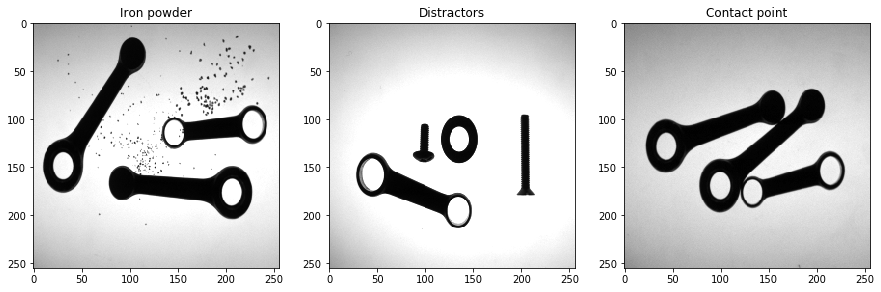

In [2]:
# Load images
img1 = cv2.imread("imgs_2/TESI92.BMP", cv2.IMREAD_GRAYSCALE)    # iron powder
img2 = cv2.imread("imgs_2/TESI49.BMP", cv2.IMREAD_GRAYSCALE)    # distractors
img3 = cv2.imread("imgs_2/TESI51.BMP", cv2.IMREAD_GRAYSCALE)    # contact point

plt.figure(figsize=(15,10))

plt.subplot(1,3,1)
plt.title("Iron powder")
plt.imshow(img1, cmap="gray")

plt.subplot(1,3,2)
plt.title("Distractors")
plt.imshow(img2, cmap="gray")

plt.subplot(1,3,3)
plt.title("Contact point")
plt.imshow(img3, cmap="gray")

plt.show()

## Iron Powder
The presence of iron powder can be seen as "salt and pepper" noise. Smoothing by a medianBlur is particulary effective, and also preserve the edges of the rods

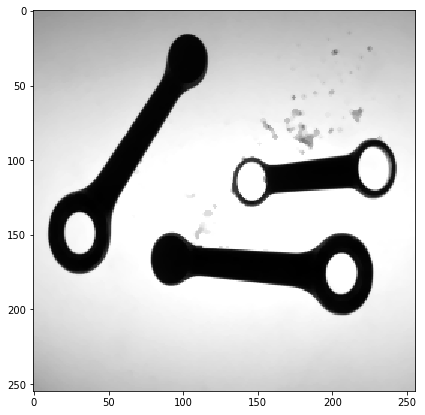

In [3]:
img_filtered = cv2.medianBlur(img1, 3)
img_filtered = cv2.medianBlur(img_filtered, 3)
img_filtered = cv2.medianBlur(img_filtered, 3)

plt.figure(figsize=(7,7))
plt.imshow(img_filtered, cmap="gray")
plt.show()

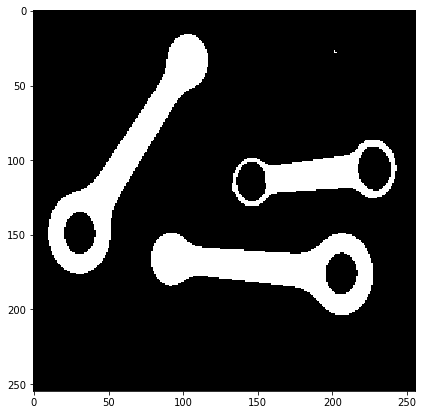

In [4]:
th_value, img_bin = cv2.threshold(img_filtered, 0, 255, cv2.THRESH_OTSU)
# img_bin = cv2.adaptiveThreshold(img_filtered, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
#                                 cv2.THRESH_BINARY, 71, 20)
# Invert binary image: white foreground, black background
img_bin = 255-img_bin

plt.figure(figsize=(7,7))
plt.imshow(img_bin, cmap="gray")
plt.show()

#print("Otsu Threshold: {}".format(th_value))

Some of the bigger residue may remain in the images. To avoid applying to much medianBlur, with the risk of ruining some edges, I've filtered components with area smaller than a certain threshold.

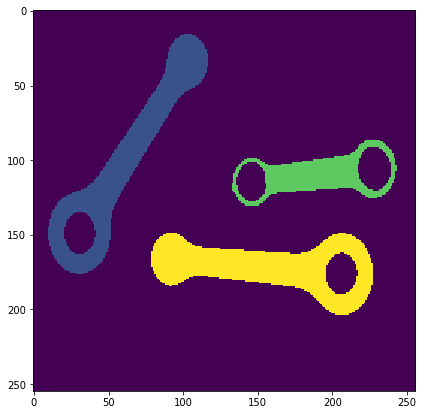

In [5]:
min_area = 100
connectivity = 8
num_labels, labels, stats, centroid = cv2.connectedComponentsWithStats(img_bin, connectivity, th_value,  cv2.CV_32S)

for i in range(1,num_labels):   #first label is background
    area = stats[i, cv2.CC_STAT_AREA]

    if area < min_area:
        labels[labels==i] = 0

plt.figure(figsize=(7,7))
plt.imshow(labels)
plt.show()


## Remove distractors
The distractors that are possible to encounter in the images are screws and washers. The screw are already discarded by the previous code, as they do not present any holes. To remove washers I've computed the Haralick circularity, and filtered the blob that have a circularity too high.

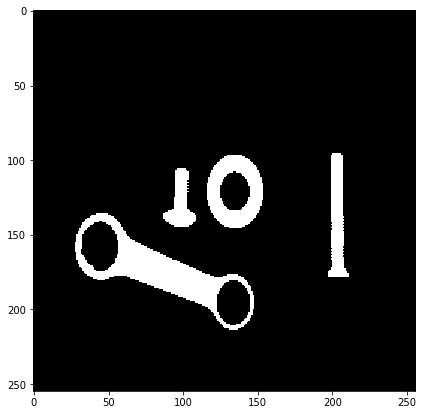

In [6]:
img_filtered = cv2.medianBlur(img2, 3)
img_filtered = cv2.medianBlur(img_filtered, 3)
img_filtered = cv2.medianBlur(img_filtered, 3)

th_value, img_bin = cv2.threshold(img_filtered, 0, 255, cv2.THRESH_OTSU)
# img_bin = cv2.adaptiveThreshold(img_filtered, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
#                                 cv2.THRESH_BINARY, 71, 20)
# Invert binary image: white foreground, black background
img_bin = 255-img_bin

plt.figure(figsize=(7,7))
plt.imshow(img_bin, cmap="gray")
plt.show()

#print("Otsu Threshold: {}".format(th_value))

In [7]:
def distance(p1, p2):
    return math.sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)

def HaralickCircularity(cont):
    moments = cv2.moments(cont)
    B = int(moments['m10']/moments['m00']), int(moments['m01']/moments['m00'])

    sum = 0
    for p in cont:
        sum += distance(B, p[0])
    
    mean = sum / len(cont)
    
    sum = 0
    for p in cont:
        sum += (distance(B, p[0]) - mean)**2
    
    variance = sum / len(cont)

    return mean/math.sqrt(variance)


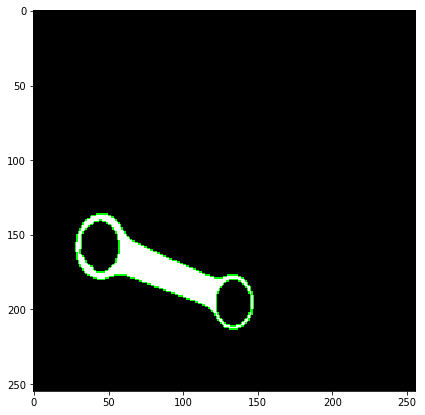

['B']


In [8]:
min_area = 100
th_circularity = 3

connectivity = 8
num_labels, labels, stats, centroid = cv2.connectedComponentsWithStats(img_bin, connectivity, th_value,  cv2.CV_32S)

rod_type = []
ext_cont = []
holes_cont = []
blobs = []

for i in range(1,num_labels):   #first label is background
    area = stats[i, cv2.CC_STAT_AREA]

    if area < min_area:     # remove small powder
        labels[labels==i] = 0
    
    blob = (labels==i).astype("uint8") * 255
    cont, hierarchy = cv2.findContours(image=blob, mode=cv2.RETR_CCOMP, method=cv2.CHAIN_APPROX_SIMPLE)

    ext_cont_i = 0
    holes_cont_i = []
    type_i = 0

    for idx, c in enumerate(hierarchy[0]):
        if c[3] == -1:  # if it has no parent, it is external
            
            if c[2] == -1:  # a rod must have at least one hole
                continue    

            # Remove washers, check circularity
            circularity = HaralickCircularity(cont[idx])
            if circularity > th_circularity:
                continue

            hole_1 = hierarchy[0][c[2]]

            if hole_1[0] == -1: # only one hole: type A
                type_i = 'A'
                ext_cont_i = cont[idx][:,0]
                holes_cont_i.append([cont[c[2]][:,0]])
                continue

            hole_2 = hierarchy[0][hole_1[0]]

            if hole_2[0] == -1: # two holes: type B
                type_i = 'B'
                ext_cont_i = cont[idx][:,0]
                holes_cont_i.append([cont[c[2]][:,0], cont[hole_1[0]][:,0]])

            continue    # a rod cannot have more than two holes
    
    
    if type_i != 0:   # append only if it is a rod
        ext_cont.append(ext_cont_i)
        holes_cont.append(holes_cont_i)
        rod_type.append(type_i)
        blobs.append(blob)

# Rebuild the image with only the blobs
temp_blob = np.zeros(img2.shape)
for blob in blobs:
    temp_blob = np.logical_or(temp_blob, blob)
temp_blob = temp_blob.astype("uint8")*255

# Redraw contours
img_cont = np.stack([temp_blob,temp_blob,temp_blob], axis=-1)   #3 channel image to draw colored contours
temp_cont, _ = cv2.findContours(image=temp_blob, mode=cv2.RETR_CCOMP, method=cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(img_cont, temp_cont, -1, (0,255,0), 1)

plt.figure(figsize=(7,7))
plt.imshow(img_cont)
plt.show()


print(rod_type)

## Remove contact points
To remove contact points, the approach I used was to search for convexity defects in the contour, and then draw a black line between close defect points. However, it was not robust, and the line was either too thin and the blob were not completely detached, or either too thick and it would ruin the hole inside the rod. Maybe this method could be improved using some binary morphology operators. For the time being it will not be added to the final implementation.

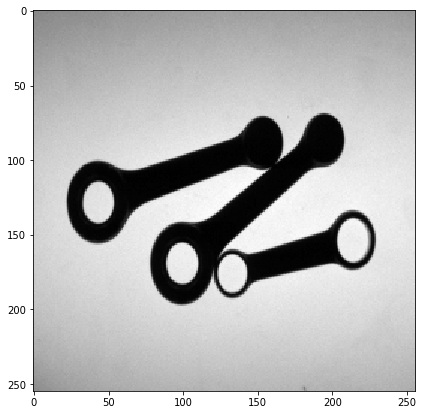

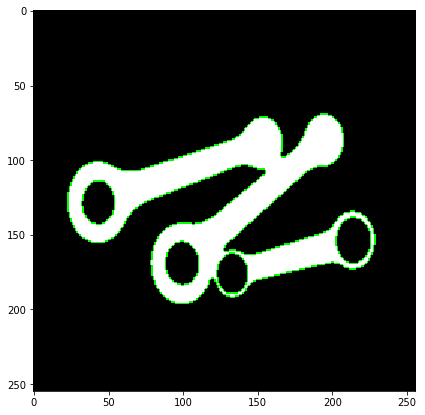

In [9]:
img_filtered = cv2.medianBlur(img3, 3)
img_filtered = cv2.medianBlur(img_filtered, 3)
img_filtered = cv2.medianBlur(img_filtered, 3)

th_value, img_bin = cv2.threshold(img_filtered, 0, 255, cv2.THRESH_OTSU)

# Invert binary image: white foreground, black background
img_bin = 255-img_bin

img_cont = np.stack([img_bin,img_bin,img_bin], axis=-1)   #3 channel image to draw colored contours
temp_cont, _ = cv2.findContours(image=img_bin, mode=cv2.RETR_CCOMP, method=cv2.CHAIN_APPROX_NONE)
cv2.drawContours(img_cont, temp_cont, -1, (0,255,0), 1)

plt.figure(figsize=(7,7))
plt.imshow(img3, cmap="gray")
plt.show()

plt.figure(figsize=(7,7))
plt.imshow(img_cont)
plt.show()


defects:  [[127 160]
 [168  98]
 [ 71 107]
 [155 107]
 [119 179]
 [190 170]]


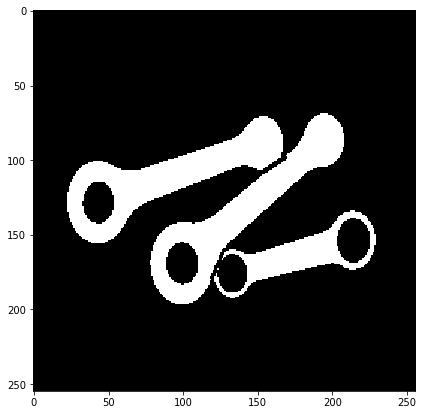

In [10]:
def findDefectPoints(cont):
    cont = cv2.approxPolyDP(cont, 5, True)

    hull_defects = cv2.convexHull(cont, returnPoints=False)
    defect_vec = cv2.convexityDefects(cont, hull_defects)

    if defect_vec is None:      # convex objects have no defect_points
        return np.array([])

    def_points = np.take(cont.squeeze(1), defect_vec.squeeze(1)[:, 2], axis=0)
    return def_points

pts = findDefectPoints(temp_cont[0])
print("defects: ", pts)

temp = np.stack([img_bin, img_bin, img_bin], axis=-1)

dist_th = 50

for i in range(0, len(pts)):
    p = pts[i]

    min_dist = 10000
    best_q = -1

    for j in range(i+1, len(pts)):
        q = pts[j]
        dist = distance(p,q)
        if dist < min_dist:
            min_dist = dist
            best_q = q

    if min_dist < dist_th:
        cv2.line(temp, (p[0],p[1]), (best_q[0],best_q[1]), (0,0,0), thickness=2, lineType=cv2.LINE_8)


# kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(2,2))
# temp = cv2.dilate(temp, kernel, iterations=1)


plt.figure(figsize=(7,7))
plt.imshow(temp)
plt.show()

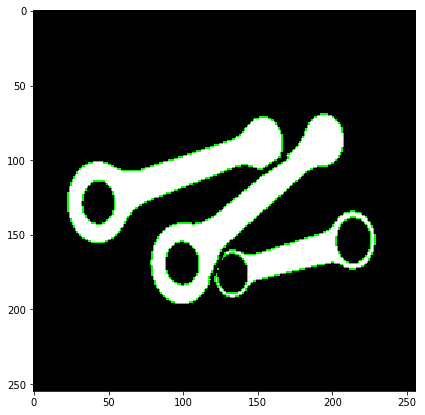

[[[ 1 -1 -1 -1]
  [ 3  0  2 -1]
  [-1 -1 -1  1]
  [ 5  1  4 -1]
  [-1 -1 -1  3]
  [-1  3  6 -1]
  [-1 -1 -1  5]]]


In [11]:
img_cont = np.copy(temp)   #3 channel image to draw colored contours
temp_cont, hierarchy = cv2.findContours(image=temp[:,:,0], mode=cv2.RETR_CCOMP, method=cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(img_cont, temp_cont, -1, (0,255,0), 1)

plt.figure(figsize=(7,7))
plt.imshow(img_cont)
plt.show()

print(hierarchy)

note that the hole is broken